# Qiskit synthesis updates

We are slowly moving in the direction of _high-level synthesis_:
* Thinking about quantum circuits using some level of abstraction
* Writing transpiler passes that exploit these abstractions

Here is what I would like to talk about today:
1. Synthesis algorithms for Cliffords, linear functions, and permutations
2. Extracting Cliffords/linear functions/permutations from quantum circuits
3. Integrating synthesis algorithms for Cliffords/linear functions/permutations into transpile flow as HighLevelSynthesis plugins
4. Extracting/resynthesizing parts of quantum circuits

## Synthesis algorithms in Qiskit

### Cliffords:
* In Qiskit represented via _Clifford_ objects.
* Added natively to quantum circuits, without converting to _Instruction_.

**Synthesis Methods**:

* Decomposition described in the paper _"Improved Simulation of Stabilizer Circuits"_ by Scott Aaronson, Daniel Gottesman (2004).
  * Historically, the first key algorithm, with good CNOT count.
  
* A "greedy" decomposition, described in the paper _"Clifford Circuit Optimization with Templates and Symbolic Pauli Gates"_ by Sergey Bravyi, Shaohan Hu, Dmitri Maslov, Ruslan Shaydulin (2021).
  * A "greedy" algorithm leading to improved CNOT count.

* Decomposition described in the paper _"Hadamard-free circuits expose the structure of the Clifford group"_ by Sergey Bravyi, Dmitry Maslov (2020).
  * Optimal CNOT-count decomposition for Cliffords over <=3 qubits. 

* __(NEW)__ Decomposition into *S-CZ-CX-H-S-CZ-H-Pauli* layers, described in the paper _"Hadamard-free circuits expose the structure of the Clifford group"_ by Sergey Bravyi, Dmitry Maslov (2020).
  * A very structured way to view Cliffords.
  * Reduces Clifford synthesis to synthesis of *CZ*, *CX*, and *CZ-CX* layers.
  * Extensible (can choose how to synthesize *CZ*, *CX*, and *CZ-CX* layers).
  * Allows tight depth/size guarantees for various connectivity constraints. For instance, depth of 7n for linear nearest-neighbor connectivity (given special implementations of *CZ* and *CZ-CX* layers).

In [31]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Clifford, random_clifford
from qiskit.synthesis.clifford import synth_clifford_greedy, synth_clifford_layers

clifford = random_clifford(5, seed=0)
print(clifford)

Clifford: Stabilizer = ['+XYZXZ', '+XZZIY', '-ZZYYI', '+IXYZY', '-YZYXY'], Destabilizer = ['-ZXXIZ', '+IYZII', '-IXXXI', '-IXXII', '-IZYIZ']


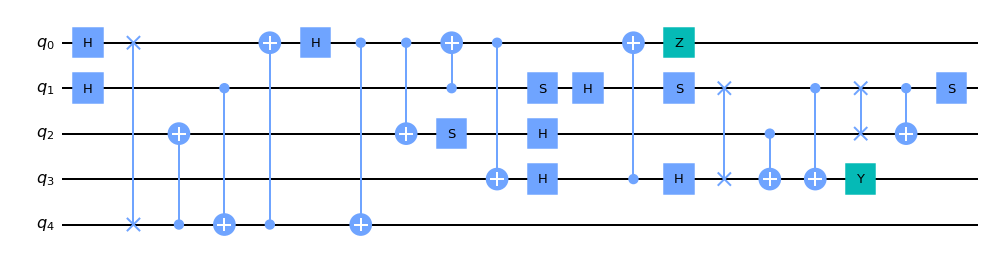

In [32]:
qc = synth_clifford_greedy(clifford)
qc.draw(output='mpl')

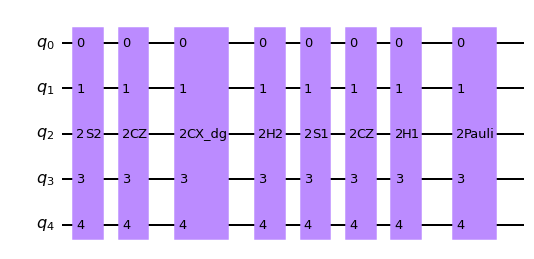

In [33]:
qc = synth_clifford_layers(clifford)
qc.draw(output='mpl')

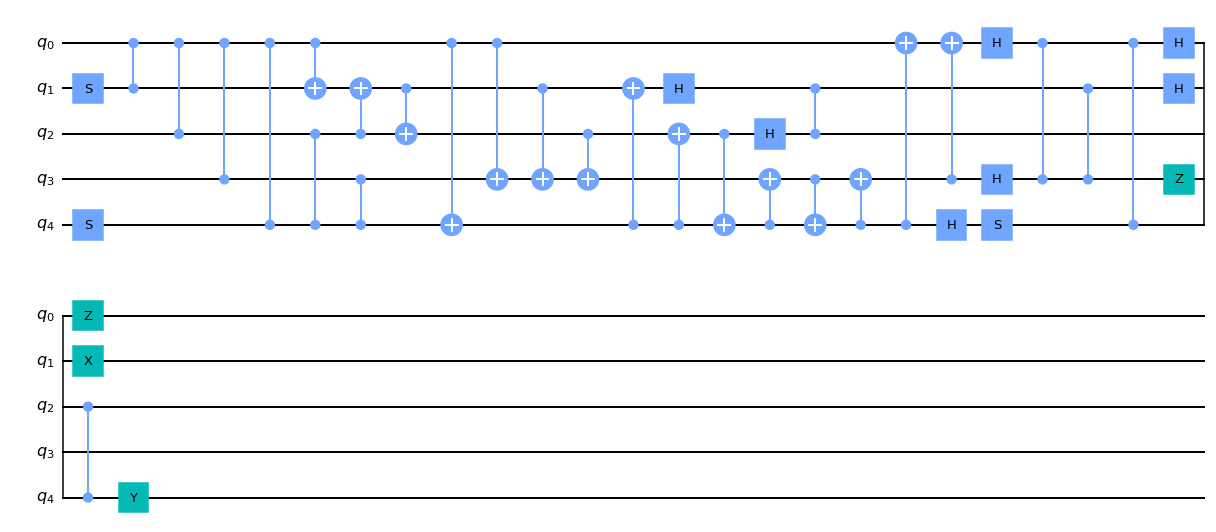

In [34]:
qc.decompose().draw(output='mpl')

### LinearFunctions 

* Linear functions are used to represent CNOT-circuits via NxN binary invertible matrices.
* In Qiskit represented via *LinearFunction* gate.

**Synthesis Methods**:

* Method based on the paper _"Optimal synthesis of linear reversible circuits"_ by Ketan N. Patel, Igor L. Markov, and John P. Hayes (2008).
  * Based on Gauss elimination; leads to good CNOT counts.
  
* __(NEW)__ Decomposition described in the paper _"Computation at a Distance"_ by Samuel A. Kutin, David Petrie Moulton, Lawren M. Smithline (2007).
  * Adheres to linear nearest-neighbor connectivity; guarantees CNOT depth of 5n.

In [35]:
import numpy as np
from qiskit.synthesis.linear import synth_cnot_count_full_pmh, synth_cnot_depth_line_kms

mat = np.array([
        [1, 1, 0, 0, 0, 0],
        [1, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 1, 0],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 1, 0],
    ])

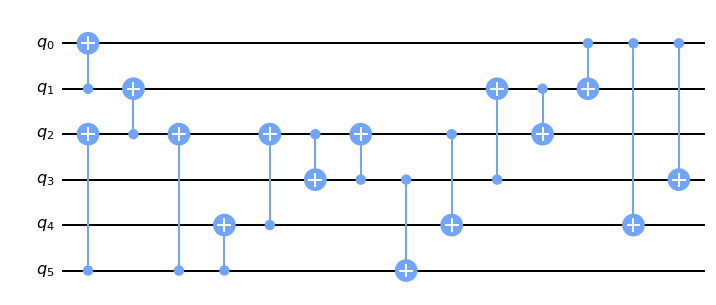

In [36]:
qc = synth_cnot_count_full_pmh(mat)
qc.draw(output='mpl')

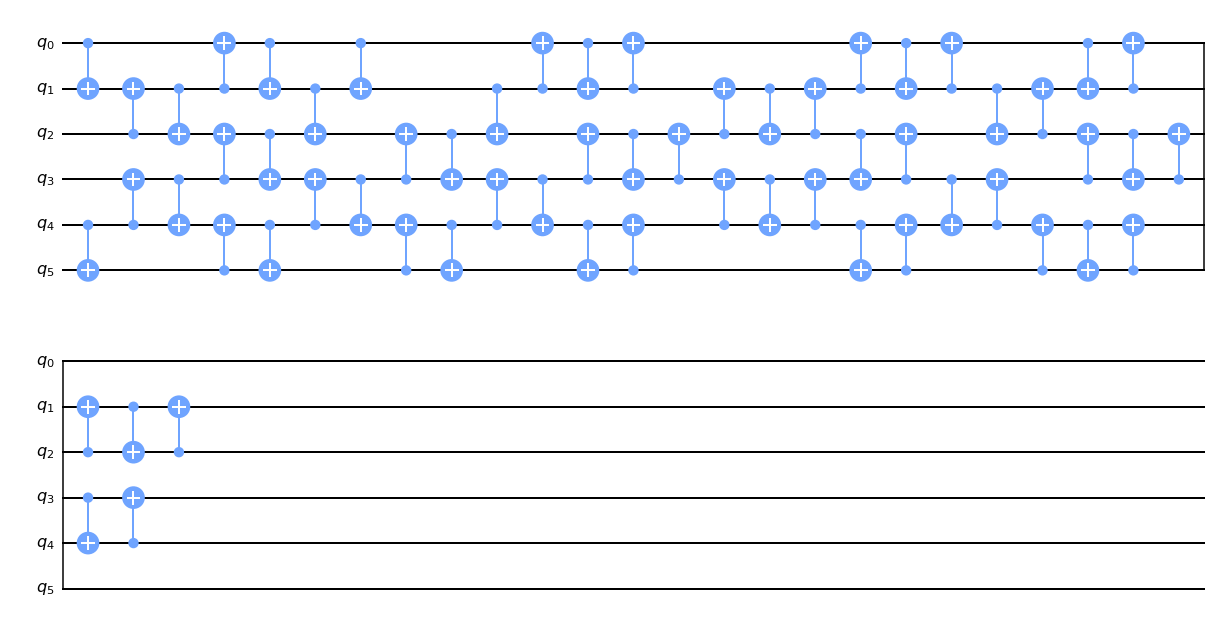

In [37]:
qc = synth_cnot_depth_line_kms(mat)
qc.draw(output='mpl')

### Permutations

* A permutation can be represented via a _permutation pattern_ that describes which qubits occupy the positions 0, 1, 2, etc. after applying the permutation.
* In Qiskit represented using _Permutation_ quantum circuits or __(NEW)__ _PermutationGate_ gates.

**Synthesis Methods**:

* __(NEW)__ Decomposition described in the paper _"Computation at a Distance"_ by Samuel A. Kutin, David Petrie Moulton, Lawren M. Smithline (2007).
  * Synthesizes a permutation using SWAP gates adhering to linear nearest-neighbor connectivity.
  * Guarantees SWAP depth of n (worst-case).

* __(NEW)__ Decomposition described in the paper _"Routing Permutations on Graphs Via Matchings"_ by Noga Alon, F. R. K. Chung, R. L. Graham (1993). 
  * Guarantees SWAP depth of at most 2 (for all-to-all connectivity). 

In [38]:
from qiskit.synthesis.permutation import synth_permutation_depth_lnn_kms, synth_permutation_acg
pattern = [1, 2, 3, 4, 5, 6, 7, 0]

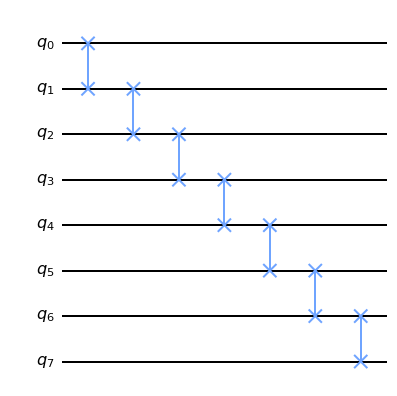

In [39]:
qc = synth_permutation_depth_lnn_kms(pattern)
qc.draw(output='mpl')

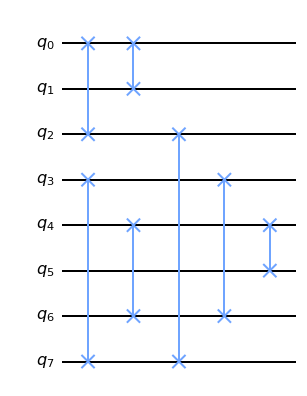

In [40]:
qc = synth_permutation_acg(pattern)
qc.draw(output='mpl')

## Collecting blocks of gates in a circuit

* __(NEW)__ _CollectAndCollapse_ is a general transpiler pass to collect and to consolidate blocks of nodes in a circuit.

* Depends on two general functions: the "collection" function and the "collapsing" function
  * *collect_function* takes a DAG and returns a list of blocks.
  * *collapse_function* takes a list of blocks and consolidates each block.

Specific passes:

* (Recent) _CollectLinearFunctions_ collects blocks of _CX_ and _SWAP_ gates and consolidates each block into a _LinearFunction_ object.
* __(NEW)__ _CollectCliffords_ collects blocks of Clifford objects (_X, Y, Z, H, S, S*, CX, CY, CZ, SWAP_ gates, _LinearFunction, Clifford, PauliGate_ objects) and consolidates each block into a _Clifford_ object.

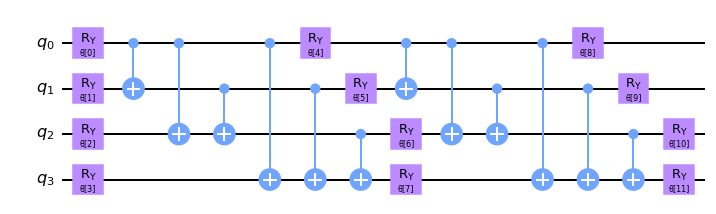

In [41]:
from qiskit.circuit.library.generalized_gates import LinearFunction
from qiskit.transpiler.passes.optimization import CollectLinearFunctions
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(4, reps=2, entanglement='full')
qc = ansatz.decompose()
qc.draw(output='mpl')

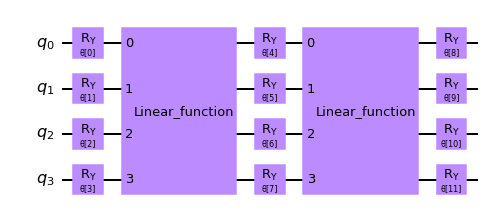

In [42]:
qc_extracted = CollectLinearFunctions()(qc)
qc_extracted.draw(output='mpl')

In this case, both _LinearFunctions_ can be synthesized more efficiently:

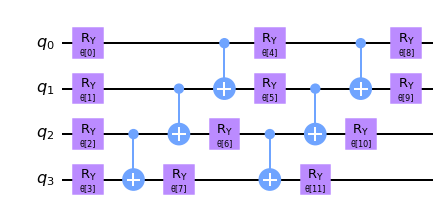

In [43]:
from qiskit.compiler import transpile
qc_transpiled = transpile(qc_extracted, optimization_level=1)
qc_transpiled.draw(output='mpl')

Both _CollectLinearFunctions_ and _CollectCliffords_ have an option to exploit _commutativity_ between gates.

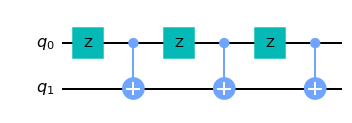

In [44]:
qc = QuantumCircuit(2)
qc.z(0)
qc.cx(0, 1)
qc.z(0)
qc.cx(0, 1)
qc.z(0)
qc.cx(0, 1)
qc.draw(output='mpl')

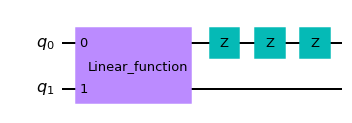

In [45]:
qc_extracted = CollectLinearFunctions(do_commutative_analysis=True)(qc)
qc_extracted.draw(output='mpl')

### Implementing similar passes:

We have a (somewhat general) collection function "collect_using_filter_function" that collects gates that match a given *filter_function*.

We also have a (somewhat general) collapsing function that consolidates blocks, based on an auxiliary function that creates a high-level object from a quantum circuit containing specific gates. 

Both _CollectLinearFunctions_ and _CollectCliffords_ are built using the above. 

For instance, for _CollectLinearFunctions_: the *filter_function* returns _True_ if a gate is either _CX_ or _SWAP_, the collapsing function creates a _LinearFunction_, the required auxiliary function produces a _LinearFunction_ out of a quantum circuit with _CX_ and _SWAP_ gates only.

It makes it easy to write other passes of this kind. Let's write a pass that collects blocks of SWAP gates and replaces each block by a _PermutationGate_.

In [46]:
from functools import partial
from qiskit.transpiler.passes.optimization.collect_and_collapse import CollectAndCollapse, collect_using_filter_function, collapse_to_operation
from qiskit.circuit.library.generalized_gates import PermutationGate

# make use of "collect_using_filter_function", where filter_function collects SWAP gates. 
my_collect_function = partial(
            collect_using_filter_function,
            filter_function=lambda node: node.op.name=="swap" and getattr(node.op, "condition", None) is None,
            split_blocks=False,
            min_block_size=2,
        )

# Given a quantum circuit with SWAP gates, create a PermutationGate out of it.
def _swap_block_to_permutation_gate(qc: QuantumCircuit):
    nq = qc.num_qubits
    pattern = list(range(nq))
    for instruction in qc.data:
        q0 = qc.find_bit(instruction.qubits[0]).index
        q1 = qc.find_bit(instruction.qubits[1]).index
    pattern[q0], pattern[q1] = pattern[q1], pattern[q0]
    return PermutationGate(pattern)


# make use of "collapse_to_operation"
my_collapse_function = partial(collapse_to_operation, collapse_function=_swap_block_to_permutation_gate)

# And that's our pass
SwapCollector = CollectAndCollapse(collect_function=my_collect_function, collapse_function=my_collapse_function)

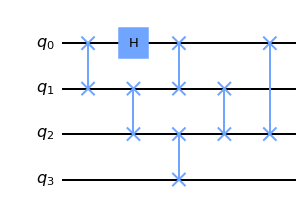

In [47]:
qc = QuantumCircuit(4)
qc.swap(0, 1)
qc.swap(1, 2)
qc.swap(2, 3)
qc.h(0)
qc.swap(0, 1)
qc.swap(1, 2)
qc.swap(2, 0)
qc.draw(output='mpl')

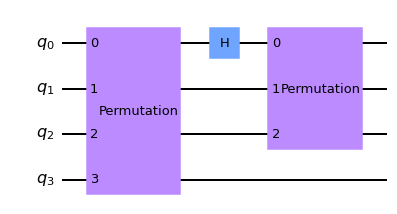

In [48]:
qc_extracted = SwapCollector(qc)
qc_extracted.draw(output='mpl')

We will also use this SwapCollector pass it a bit later in this notebook.

## Integrating synthesis algorithms via HighLevelSynthesis plugins

* The plan is to decompose "high-level objects" (for instance, _Cliffords_, _LinearFunctions_, _PermutationGates_) using _HighLevelSynthesis_ transpiler pass. 
* Each object can be decomposed using multiple algorithms available as HighLevelSynthesis plugins.
  * This is quite similar to unitary synthesis plugins or stage pass manager plugins.
* _Modular and extensible_: plugins can be implemented in external packages (by anyone in the community).
* As of Qiskit 0.23, plugings do not yet have support for the coupling map, so can be only used on the abstract quantum circuit, i.e. before layout/routing/optimization loop. 
* Note: Qiskit 0.23 defines *non-default* HighLevelSynthesis plugins only for _PermutationGates_.
  * Note: _PR9399_ (not yet in Qiskit) defines synthesis plugins for _LinearFunctions_ and for _Cliffords_.

Let's create a quantum circuit with several high-level-objects 

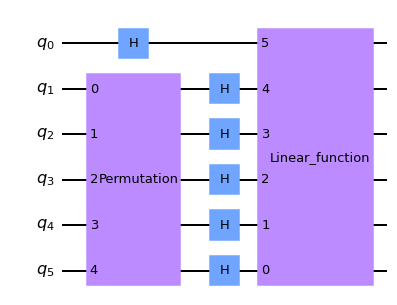

In [49]:
qc = QuantumCircuit(6)

# Let's append a permutation gate and a linear function
qc.append(PermutationGate([1, 2, 3, 4, 0]), [1, 2, 3, 4, 5])
qc.h(range(6))
mat = np.array([
        [1, 1, 0, 0, 0, 0],
        [1, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 1, 0],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 1, 0],
    ])
qc.append(LinearFunction(mat), [5, 4, 3, 2, 1, 0])
qc.draw(output='mpl')

We can transpile the high-level-objects using the "default" synthesis methods.

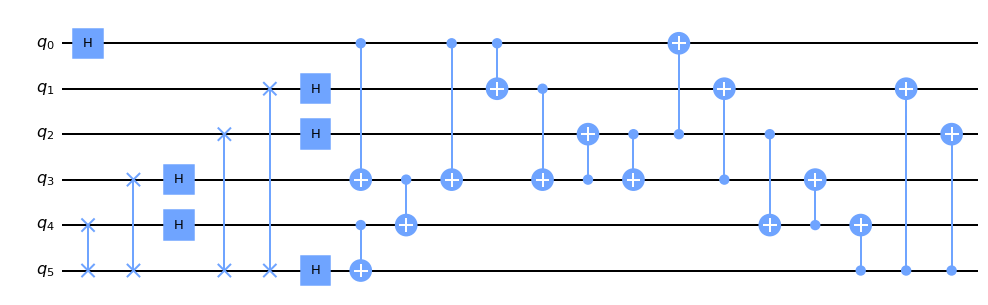

In [50]:
from qiskit.compiler import transpile
qc_transpiled = transpile(qc, optimization_level=1)
qc_transpiled.draw(output='mpl')

Let's specify a different synthesis method for permutations:

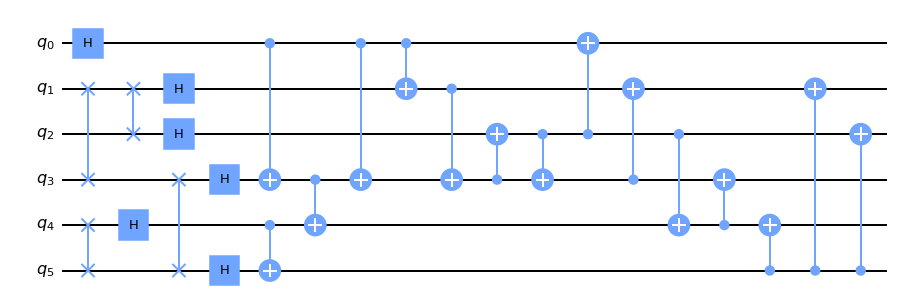

In [51]:
from qiskit.transpiler.passes.synthesis.high_level_synthesis import HLSConfig, HighLevelSynthesis
hls_config=HLSConfig(
    permutation=[("acg", {})],
)
qc_transpiled = transpile(qc, optimization_level=1, hls_config=hls_config)
qc_transpiled.draw(output='mpl')

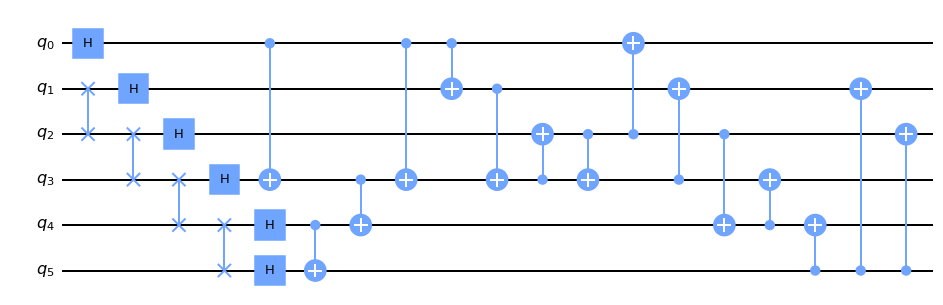

In [52]:
from qiskit.transpiler.passes.synthesis.high_level_synthesis import HLSConfig, HighLevelSynthesis
hls_config=HLSConfig(
    permutation=[("kms", {})],
)
qc_transpiled = transpile(qc, optimization_level=1, hls_config=hls_config)
qc_transpiled.draw(output='mpl')

We can see that the permutation is synthesized differently both times!

We also have a simple way to synthesize _only_ specific high-level-gates:

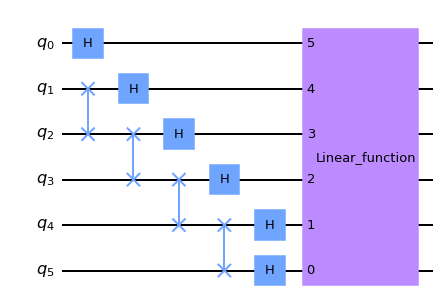

In [53]:
from qiskit.transpiler.passes.synthesis.high_level_synthesis import HLSConfig, HighLevelSynthesis
hls_config=HLSConfig(
    use_default_on_unspecified=False,
    permutation=[("kms", {})],
)
qc_transpiled = transpile(qc, optimization_level=1, hls_config=hls_config)
qc_transpiled.draw(output='mpl')

## Extracting and resynthesizing parts of quantum circuits

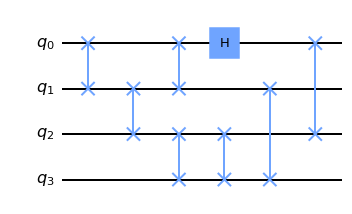

In [54]:
qc = QuantumCircuit(4)
qc.swap(0, 1)
qc.swap(1, 2)
qc.swap(2, 3)
qc.swap(1, 0)
qc.swap(2, 3)
qc.swap(3, 1)
qc.h(0)
qc.swap(0, 2)
qc.draw(output='mpl')

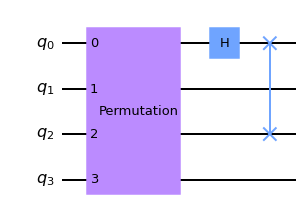

In [55]:
# Use our SwapCollector to extract SWAP blocks and to replace them by PermutationGates
qc_extracted = SwapCollector(qc)
qc_extracted.draw(output='mpl')

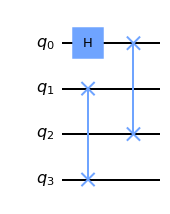

In [56]:
# Resynthesize using 'acg' method
hls_config = hls_config=HLSConfig(
    permutation=[("acg", {})],
)
qc_resynthesized = HighLevelSynthesis(hls_config=hls_config)(qc_extracted)
qc_resynthesized.draw(output='mpl')

## Underway and in future:

* Clifford synthesis for linear nearest-neighbor architecture in depth of 7n
* Integrate coupling_map into _HighLevelSynthesis_
* Explore resynthesis of high-level objects as part of the transpiler optimization loop
* Passes based on the high-level representation of objects (e.g., we could write a pass to compose consecutive permutations gates)

## See also:

* Qiskit v0.40 release news: https://medium.com/qiskit/release-news-qiskit-v0-40-is-here-cdcdc8d400d4
* Qiskit Breaking Changes: https://www.youtube.com/watch?v=v-s83q9t9Nw
* Terra 0.23.0 release notes: https://qiskit.org/documentation/release_notes.html#terra-0-23-0

## Thank you!